# P6 - Catégorisez automatiquement des questions
# Exploration non supervisée

In [1]:
### PARAMETRAGE ###
SAMPLE = False
NSAMPLEMAX = 30000
### PARAMETRAGE ###

## Importation des librairies

In [2]:
# Librairies classiques
import pandas as pd
import numpy as np
import pickle
from time import time

# Librairies graphiques
import matplotlib.pyplot as plt
%matplotlib inline

# Librairies de traitement de texte
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from p6_functions import *
CT_DIR_SAVE = '../autotag/save/'

## Récupération des données

In [3]:
df_train = pd.read_csv(CT_DIR_SAVE + 'df_train.csv')
df_test = pd.read_csv(CT_DIR_SAVE + 'df_test.csv')

In [4]:
print(df_train.shape)
print(df_test.shape)
dataraw = df_train.append(df_test)
print(dataraw.shape)
dataraw.head()

if SAMPLE:
    dataraw = dataraw.sample(10000)
if dataraw.shape[0]>NSAMPLEMAX:
    dataraw = dataraw.sample(NSAMPLEMAX)
    

(152855, 2)
(38214, 2)
(191069, 2)


In [5]:
all_tags_loaded = load_obj(CT_DIR_SAVE + 'all_tags')

# Pour noter les topics trouvés on va récupérer les mots des tags sans les tirets
all_tags = []
for word in all_tags_loaded:
    for w in word.split('-'):
        if len(w)>1:
            all_tags.append(w)
all_tags = sorted(set(all_tags))
len(all_tags)

../autotag/save/all_tags loaded


11385

## Analyse de Sparsicity

### Sparsicity vs Taille échantillon

In [6]:
max_df=.8
min_df=5
max_features=10000

*************************\Done in 84.013s.


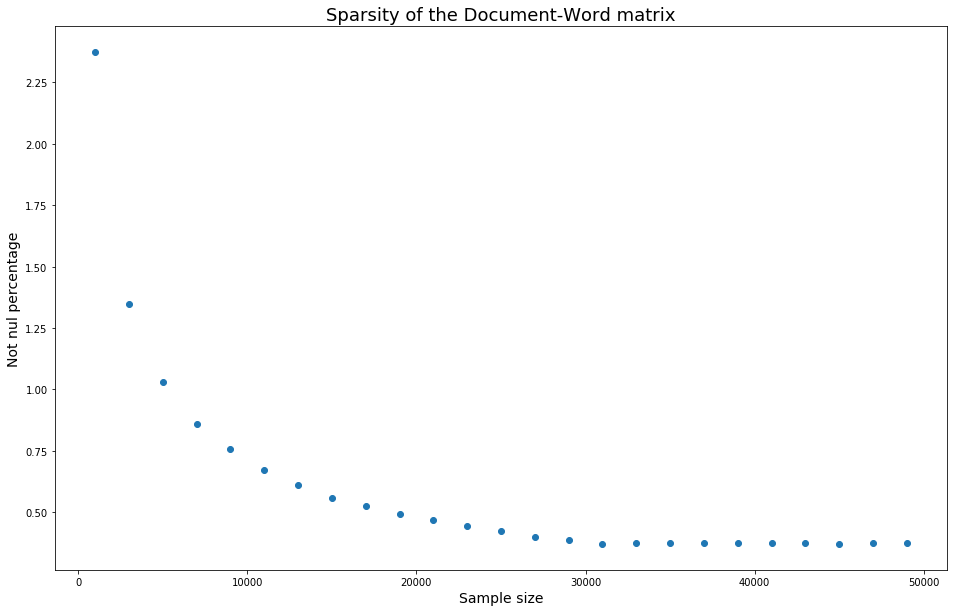

In [7]:
if not SAMPLE:
    sparse = []
    r = range(1000, 50000, 2000)
    t0 = time()
    for i in r:
        df = df_train.sample(i)
        print('*', end='')

        # Vectorizer
        vect = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
        tf = vect.fit_transform(df['TextCleaned'])

        # Materialize the sparse data
        data_dense = tf.todense()
        # Compute Sparsicity = Percentage of Non-Zero cells
        sparse.append(((data_dense > 0).sum()/data_dense.size)*100)
        #print("\tPourcentage de points non nuls (Sparsicity) : ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
        del data_dense

    print("\Done in %0.3fs." % (time() - t0))
    plt.figure(figsize=(16,10))
    plt.title('Sparsity of the Document-Word matrix', fontsize=18)
    plt.xlabel('Sample size', fontsize=14)
    plt.ylabel('Not nul percentage', fontsize=14)
    plt.scatter(r, sparse)

### Sparsicity vs Taille features

**********\Done in 38.050s.


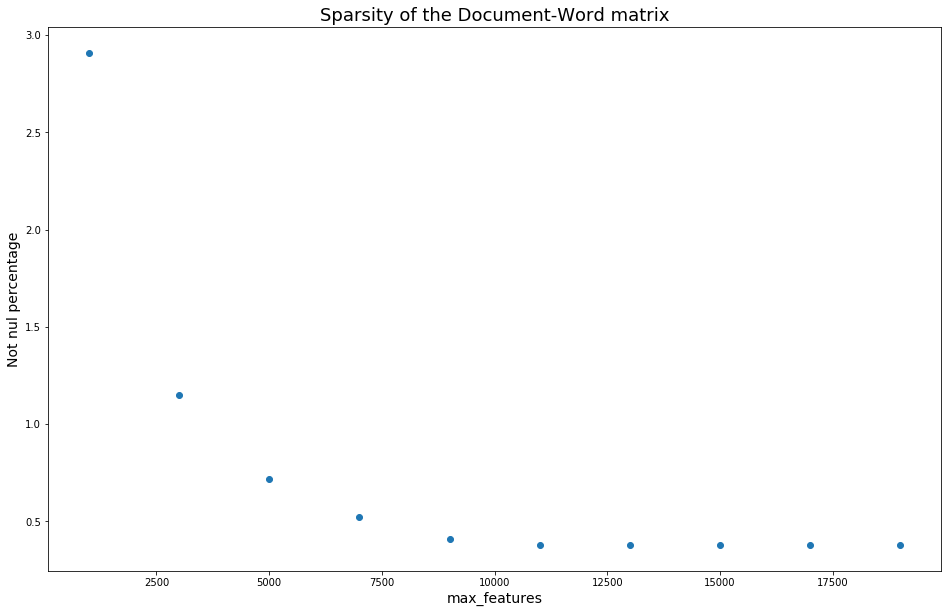

In [8]:
if not SAMPLE:
    sparse = []
    # Echantillon max pour la mémoire : 30000
    df = df_train.sample(30000)
    r = range(1000, 20000, 2000)
    t0 = time()
    for i in r:
        print('*', end='')

        # Vectorizer
        vect = CountVectorizer(max_df=max_df, min_df=min_df, max_features=i, stop_words='english')
        tf = vect.fit_transform(df['TextCleaned'])

        # Materialize the sparse data
        data_dense = tf.todense()
        # Compute Sparsicity = Percentage of Non-Zero cells
        sparse.append(((data_dense > 0).sum()/data_dense.size)*100)
        #print("\tPourcentage de points non nuls (Sparsicity) : ", ((data_dense > 0).sum()/data_dense.size)*100, "%")
        del data_dense

    print("\Done in %0.3fs." % (time() - t0))
    plt.figure(figsize=(16,10))
    plt.title('Sparsity of the Document-Word matrix', fontsize=18)
    plt.xlabel('max_features', fontsize=14)
    plt.ylabel('Not nul percentage', fontsize=14)
    plt.scatter(r, sparse)

## Create the Document-Word matrix

In [14]:
# Vectorizer
t0 = time()
max_df=.8
min_df=5
max_features=10000
vect = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, stop_words='english')
tf = vect.fit_transform(dataraw['TextCleaned'])
print("Vectorizer done in %0.3fs." % (time() - t0))

Vectorizer done in 2.888s.


## Réduction dimensionnelle

In [10]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

### TSVD

In [15]:
# Conduct TSVD
t0 = time()
tsvd = TruncatedSVD(n_components=tf.shape[1]-1)
X_tsvd = tsvd.fit(tf)
print("TruncatedSVD done in %0.3fs." % (time() - t0))
select_n_components(tsvd.explained_variance_ratio_, 0.95)

TruncatedSVD done in 3935.522s.


1845

### PCA

In [11]:
# Conduct PCA
t0 = time()
pca = PCA(n_components=0.95, whiten=True)
# Pas sparse donc le toarray()
X_pca = pca.fit_transform(tf.toarray())
print("PCA done in %0.3fs." % (time() - t0))
print('Original number of features:', tf.shape[1])
print('Reduced number of features:', X_pca.shape[1])

PCA done in 2294.979s.
Original number of features: 10000
Reduced number of features: 1845


500
PCA done in 2.376s.
Original number of features: 500
Reduced number of features: 341
700
PCA done in 2.464s.
Original number of features: 700
Reduced number of features: 449
900
PCA done in 3.725s.
Original number of features: 900
Reduced number of features: 545
1100
PCA done in 4.296s.
Original number of features: 1100
Reduced number of features: 633
1300
PCA done in 5.925s.
Original number of features: 1300
Reduced number of features: 712
1500
PCA done in 8.253s.
Original number of features: 1500
Reduced number of features: 780
1700
PCA done in 9.652s.
Original number of features: 1700
Reduced number of features: 843
1900
PCA done in 12.282s.
Original number of features: 1900
Reduced number of features: 900
2100
PCA done in 15.450s.
Original number of features: 2100
Reduced number of features: 953
2300
PCA done in 18.927s.
Original number of features: 2300
Reduced number of features: 999
2500
PCA done in 23.154s.
Original number of features: 2500
Reduced number of features: 1040


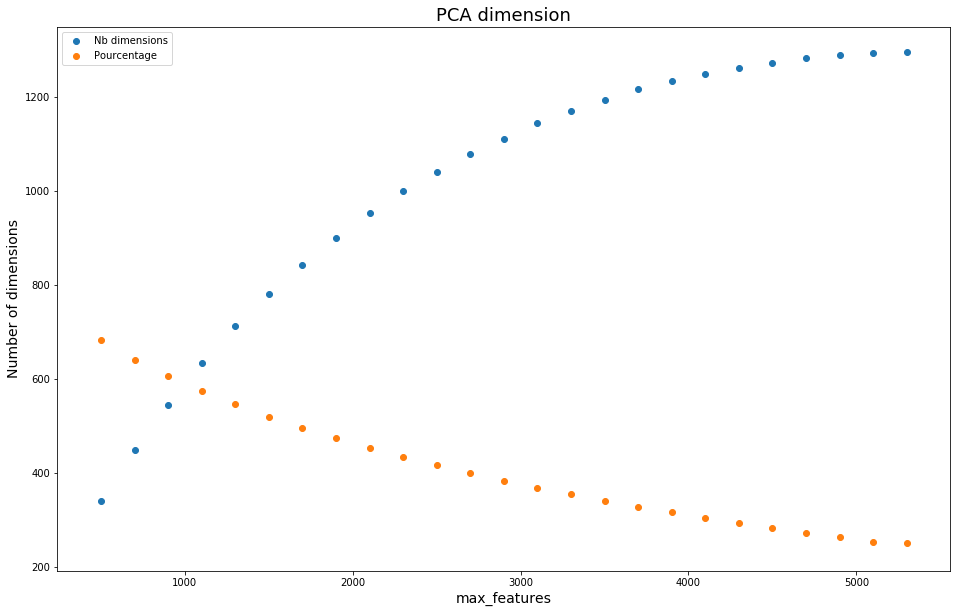

In [12]:
if not SAMPLE:
    nDim = []
    nDimP = []
    # On prend quand même un échantillon pour la mémoire
    df = dataraw.sample(10000)
    r = range(500, 5500, 200)

    for max_feat in r:
        print(max_feat)
        # Vectorizer
        t0 = time()
        vect = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_feat, stop_words='english')
        tf = vect.fit_transform(df['TextCleaned'])

        pca = PCA(n_components=0.95, whiten=True)
        # Pas sparse donc le toarray()
        X_pca = pca.fit_transform(tf.toarray())
        print("PCA done in %0.3fs." % (time() - t0))
        print('Original number of features:', tf.shape[1])
        print('Reduced number of features:', X_pca.shape[1])
        nDim.append(X_pca.shape[1])
        nDimP.append(X_pca.shape[1] / tf.shape[1])

        del pca
        del tf
        del vect

    plt.figure(figsize=(16,10))
    plt.title('PCA dimension', fontsize=18)
    plt.xlabel('max_features', fontsize=14)
    plt.ylabel('Number of dimensions', fontsize=14)
    plt.scatter(r, nDim, label='Nb dimensions')
    plt.scatter(r, [x*1000 for x in nDimP], label='Pourcentage')
    plt.legend()


## Mode non supervisé - Analyse de Title+Body

On va maintenant essayer d'extraire des clusters de notre nouvelle feature, d'abord avec LDA ensuite avec NMF

In [16]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

mystops = set(stopwords.words("english"))

In [17]:
no_topics = 50
no_top_words = 5

# Méthode de scoring d'affichage des mots clés de chaque groupe
def score(vect, mod, name, display=False):
    t0 = time()
    tf = vect.fit_transform(dataraw['TextCleaned'])
    mod.fit(tf)
    if display:
        print("done in %0.3fs." % (time() - t0))

    # On va compter les mots clés des topics qui sont aussi des tags
    # Plus on en aura, mieux le modèle sera noté
    total_matches = 0
    feature_names = vect.get_feature_names()
    for topic_idx, topic in enumerate(mod.components_):
        if display: print ("Topic %d " % (topic_idx), end=' ')
        topic_top_words_index = topic.argsort()[:-no_top_words - 1:-1]
        n = 0
        for i in topic_top_words_index:
            if feature_names[i] in all_tags:
                n += 1
        total_matches += n
        if display: print ("(%d matchs) :" % (n), end=' ')
        if display: print (" ".join([feature_names[i] for i in topic_top_words_index]))
    nmax = no_topics * no_top_words
    note = total_matches/nmax
    print("Note=%.2f, (%d matches sur %d possibles - %s)" % (note, total_matches, nmax, name))
    
    if display: 
        print()
        predict = mod.transform(tf)
        for n in range(10):
            topic_most_pr = predict[n].argmax()
            print("doc {}, topic {}, {}...".format(n, topic_most_pr, dataraw.TextCleaned.iloc[n][:50]))
    
    return note

### LDA

In [18]:
# LDA avec CountVectorizer

def scoreLDA(max_df, min_df, max_features, display=False):
    vect = CountVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, 
                           stop_words='english')

    mod = LatentDirichletAllocation(n_components=no_topics, max_iter=10, learning_method='online', 
                                    learning_offset=50., random_state=0)
    name = 'LDA max=%.1f - min=%i - feat=%i' % (max_df, min_df, max_features)
    return score(vect, mod, name, display)

### NMF

In [19]:
# NMF avec TfidfVectorizer

def scoreNMF(max_df, min_df, max_features, loss='frobenius', display=False):
    vect = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features, 
                           stop_words='english')
    
    mod = NMF(n_components=no_topics, alpha=.1, l1_ratio=.5, beta_loss=loss, solver='mu', 
              max_iter=200, random_state=0)
    name = 'NMF max=%.1f - min=%i - feat=%i' % (max_df, min_df, max_features)
    return score(vect, mod, name, display)

### Comparaison

In [20]:
no_topics = 15
no_top_words = 10
t0 = time()
print("MIN")
p_min = [5, 10, 20]
for m in p_min:
    scoreLDA(.8, m, 10000)
    scoreNMF(.8, m, 10000)
print("MAX")
p_max = [.5, .8, .9]
for m in p_max:
    scoreLDA(m, 5, 10000)
    scoreNMF(m, 5, 10000)
print("FEATURES")
p_feat = [1000, 10000, 100000]
for m in p_feat:
    scoreLDA(.8, 5, m)
    scoreNMF(.8, 5, m)

print("NMF loss")
scoreNMF(.8, 5, 10000, loss='frobenius')
scoreNMF(.8, 5, 10000, loss='kullback-leibler')

print("done in %0.3fs." % (time() - t0))

MIN
Note=0.78, (117 matches sur 150 possibles - LDA max=0.8 - min=5 - feat=10000)
Note=0.80, (120 matches sur 150 possibles - NMF max=0.8 - min=5 - feat=10000)
Note=0.75, (113 matches sur 150 possibles - LDA max=0.8 - min=10 - feat=10000)
Note=0.79, (118 matches sur 150 possibles - NMF max=0.8 - min=10 - feat=10000)
Note=0.81, (121 matches sur 150 possibles - LDA max=0.8 - min=20 - feat=10000)
Note=0.75, (113 matches sur 150 possibles - NMF max=0.8 - min=20 - feat=10000)
MAX
Note=0.75, (113 matches sur 150 possibles - LDA max=0.5 - min=5 - feat=10000)
Note=0.79, (119 matches sur 150 possibles - NMF max=0.5 - min=5 - feat=10000)
Note=0.78, (117 matches sur 150 possibles - LDA max=0.8 - min=5 - feat=10000)
Note=0.80, (120 matches sur 150 possibles - NMF max=0.8 - min=5 - feat=10000)
Note=0.78, (117 matches sur 150 possibles - LDA max=0.9 - min=5 - feat=10000)
Note=0.80, (120 matches sur 150 possibles - NMF max=0.9 - min=5 - feat=10000)
FEATURES
Note=0.79, (118 matches sur 150 possibles -

In [21]:
no_topics = 50
no_top_words = 5
t0 = time()
print("MIN")
p_min = [5, 10, 20]
for m in p_min:
    scoreLDA(.8, m, 10000)
    scoreNMF(.8, m, 10000)
print("MAX")
p_max = [.5, .8, .9]
for m in p_max:
    scoreLDA(m, 5, 10000)
    scoreNMF(m, 5, 10000)
print("FEATURES")
p_feat = [1000, 10000, 100000]
for m in p_feat:
    scoreLDA(.8, 5, m)
    scoreNMF(.8, 5, m)

print("NMF loss")
scoreNMF(.8, 5, 10000, loss='frobenius')
scoreNMF(.8, 5, 10000, loss='kullback-leibler')

print("done in %0.3fs." % (time() - t0))

MIN
Note=0.70, (176 matches sur 250 possibles - LDA max=0.8 - min=5 - feat=10000)
Note=0.79, (198 matches sur 250 possibles - NMF max=0.8 - min=5 - feat=10000)
Note=0.72, (180 matches sur 250 possibles - LDA max=0.8 - min=10 - feat=10000)
Note=0.80, (199 matches sur 250 possibles - NMF max=0.8 - min=10 - feat=10000)
Note=0.74, (184 matches sur 250 possibles - LDA max=0.8 - min=20 - feat=10000)
Note=0.79, (197 matches sur 250 possibles - NMF max=0.8 - min=20 - feat=10000)
MAX
Note=0.67, (167 matches sur 250 possibles - LDA max=0.5 - min=5 - feat=10000)
Note=0.77, (192 matches sur 250 possibles - NMF max=0.5 - min=5 - feat=10000)
Note=0.70, (176 matches sur 250 possibles - LDA max=0.8 - min=5 - feat=10000)
Note=0.79, (198 matches sur 250 possibles - NMF max=0.8 - min=5 - feat=10000)
Note=0.70, (176 matches sur 250 possibles - LDA max=0.9 - min=5 - feat=10000)
Note=0.79, (198 matches sur 250 possibles - NMF max=0.9 - min=5 - feat=10000)
FEATURES
Note=0.76, (190 matches sur 250 possibles -

### Meilleur modèle LDA

In [22]:
# Détail du meilleur modèle
no_topics = 15
no_top_words = 10
scoreLDA(.8, 5, 10000, display=True)

done in 124.890s.
Topic 0  (6 matchs) : sql select queri thread databas td server tabl option group
Topic 1  (7 matchs) : java org eclips activ excel apach core tag jar com
Topic 2  (6 matchs) : item foo properti bind bar wpf grid compon valu window
Topic 3  (8 matchs) : php echo stack mysql 32 64 port 02 zend certif
Topic 4  (8 matchs) : file use server applic web user net servic work client
Topic 5  (8 matchs) : div html imag text javascript function content page style color
Topic 6  (7 matchs) : int self templat char size const std iphon doubl pointer
Topic 7  (8 matchs) : xml date node 10 2009 00 format 11 12 xsl
Topic 8  (7 matchs) : id tabl row valu data column field key databas user
Topic 9  (7 matchs) : use like way code need time want know look work
Topic 10  (10 matchs) : string object public class return new method type use function
Topic 11  (8 matchs) : class model map view object entiti email interfac pattern use
Topic 12  (9 matchs) : file project error visual line compi

0.78

In [23]:
# GridSearch d'optimisation
from sklearn.model_selection import GridSearchCV

t0 = time()
vect = CountVectorizer(max_df=.8, min_df=5, max_features=10000, stop_words='english')
tf = vect.fit_transform(dataraw['TextCleaned'])
print("CountVectorizer done in %0.3fs." % (time() - t0))

# Define Search Param
search_params = {'n_components': [10, 30, 50], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
t0 = time()
model.fit(tf)
print("GridSearchCV done in %0.3fs." % (time() - t0))

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

CountVectorizer done in 2.430s.
GridSearchCV done in 3142.947s.
Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -4731317.60735
Model Perplexity:  1243.46472949


In [24]:
best_lda_model.n_components

10

### Meilleur modèle NMF

In [25]:
no_topics = 50
no_top_words = 5
scoreNMF(.5, 5, 10000, display=True)

done in 12.589s.
Topic 0  (4 matchs) : code like way need work
Topic 1  (4 matchs) : valu int return key null
Topic 2  (3 matchs) : tabl sql server column queri
Topic 3  (4 matchs) : page control load html aspx
Topic 4  (4 matchs) : file directori folder upload open
Topic 5  (5 matchs) : net asp mvc web server
Topic 6  (4 matchs) : string charact public convert char
Topic 7  (4 matchs) : class public interfac static void
Topic 8  (2 matchs) : project build solut eclips sourc
Topic 9  (5 matchs) : window server run xp open
Topic 10  (2 matchs) : imag png jpg img width
Topic 11  (4 matchs) : div css html width style
Topic 12  (4 matchs) : servic web wcf client site
Topic 13  (4 matchs) : test unit run mock junit
Topic 14  (5 matchs) : xml data node document element
Topic 15  (3 matchs) : collect garbag linq element ienumer
Topic 16  (4 matchs) : list sharepoint sort item li
Topic 17  (4 matchs) : process run start kill memori
Topic 18  (4 matchs) : java eclips org jar lang
Topic 19  (4 m

0.768

### Analyse du meilleur modèle LDA

In [26]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

In [27]:
best_model = best_lda_model

In [28]:
# Create Document - Topic Matrix
model_output = best_model.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(dataraw))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0,0,0.03,0.96,0,0,0,0,0,0,3
Doc1,0,0,0,0,0.98,0,0,0,0,0,4
Doc2,0,0.26,0,0.07,0.54,0,0,0,0.11,0,4
Doc3,0.03,0,0,0.65,0.01,0,0.03,0.27,0,0,3
Doc4,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.64,0.3,0.01,7
Doc5,0,0,0,0,0.41,0.06,0,0.52,0,0,7
Doc6,0.15,0,0.02,0,0.34,0.18,0,0.13,0.17,0,4
Doc7,0.16,0,0,0.69,0,0,0,0.15,0,0,3
Doc8,0.08,0,0,0,0,0,0,0,0.9,0,8
Doc9,0.57,0.01,0.01,0.01,0.01,0.01,0.08,0.01,0.01,0.31,0


In [29]:
def topics_distib(mod, tf):
    # Create Document - Topic Matrix
    lda_output = mod.transform(tf)

    # column names
    topicnames = ["Topic" + str(i) for i in range(mod.n_components)]

    # index names
    docnames = ["Doc" + str(i) for i in range(len(dataraw))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
    df_topic_distribution.columns = ['Topic Num', 'Num Documents']
    display(df_topic_distribution)

### Analyse du meilleur modèle NMF

In [39]:
# On peut reprendre l'ensembles des données
dataraw = df_train.append(df_test)

In [40]:
t0 = time()
vect = TfidfVectorizer(max_df=.5, min_df=5, max_features=10000, stop_words='english')
best_nmf_model = NMF(n_components=50, alpha=.1, l1_ratio=.5, solver='mu', max_iter=200, random_state=0)
tf = vect.fit_transform(dataraw['TextCleaned'])
best_nmf_model.fit(tf)
topics_distib(best_nmf_model, tf)
print("Done in %0.3fs." % (time() - t0))

,Topic Num,Num Documents
0,0,30905
1,4,8305
2,1,7259
3,2,6794
4,6,5455
5,7,5326
6,5,4658
7,8,4325
8,9,4260
9,10,4249


In [41]:
best_model = best_nmf_model

In [42]:
# Create Document - Topic Matrix
model_output = best_model.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(dataraw))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(model_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,Topic36,Topic37,Topic38,Topic39,Topic40,Topic41,Topic42,Topic43,Topic44,Topic45,Topic46,Topic47,Topic48,Topic49,dominant_topic
Doc0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0.01,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Doc1,0,0,0,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
Doc2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32
Doc3,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Doc4,0,0,0,0,0,0,0.01,0,0,0.01,0,0.01,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0.03,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,26
Doc5,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13
Doc6,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29
Doc7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,15
Doc8,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0,12
Doc9,0,0,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


### Méthode supervisée

Maintenant qu'on a les topics associés aux questions on peut entrainer un modèle qui permet de classer n'importe quelle question dans un topic, dont on pourra lui attribuer les mots clés. 

In [43]:
from sklearn.preprocessing import LabelEncoder

# Classification simple: LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(dominant_topic)
y = label_encoder.transform(dominant_topic)
#print(y)
#label_encoder.classes_

In [44]:
#dataraw['dominant_topic'] = dominant_topic

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataraw['TextCleaned'], dominant_topic, test_size=0.3)

In [45]:
vect = TfidfVectorizer(max_df=.5, min_df=5, max_features=10000, stop_words='english')
tf_train = vect.fit_transform(X_train)
tf_test = vect.transform(X_test)

In [49]:
print(df_train.shape)
print(df_test.shape)

(152855, 2)
(38214, 2)


In [50]:
dominant_topic.shape

(191069,)

In [51]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

t0 = time()
model_to_set = OneVsRestClassifier(LinearSVC())

parameters = {
    "estimator__C": [0.1,1,10,100],
}

model_tunning = GridSearchCV(model_to_set, param_grid=parameters, scoring='accuracy')
model_tunning.fit(tf_train, label_encoder.transform(y_train))

print("Done in %0.3fs." % (time() - t0))
print ("Accuracy Score: ", accuracy_score(label_encoder.transform(y_test), model_tunning.best_estimator_.predict(tf_test)))
model_tunning.best_estimator_

Done in 500.807s.
Accuracy Score:  0.813000471032


OneVsRestClassifier(estimator=LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1)

Le soucis de cette méthode est qu'il y a autant de listes de mots clés que de topics, donc beaucoup moins de possibilités que si on va choisir des mots clés un par un.

On va donc se tourner vers une méthode supervisée dans le prochain notebook